<a href="https://colab.research.google.com/github/Spandana365/3_Bias-Busters/blob/main/ai_res_scr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Resume Screening.csv

In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import files

uploaded = files.upload()  # Opens a file upload dialog

Saving Resume Screening.csv to Resume Screening.csv


In [3]:
# Load dataset
df = pd.read_csv("Resume Screening.csv")

import re

# Gender-neutral replacements
gendered_words = {
    "he": "they", "she": "they", "him": "them", "her": "them",
    "chairman": "chairperson", "salesman": "salesperson",
    "businessman": "businessperson", "Mr": "Candidate", "Ms": "Candidate"
}

def remove_gender_bias(text):
    for word, replacement in gendered_words.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text, flags=re.IGNORECASE)
    return text

# Preprocessing
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [4]:

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert labels to numbers
category_mapping = {cat: i for i, cat in enumerate(df['Category'].unique())}
df['Label'] = df['Category'].map(category_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Resume'], df['Label'], test_size=0.2, random_state=42)
train_dataset = ResumeDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len=128)
test_dataset = ResumeDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(category_mapping))
model.to(device)

# Training
epochs = 3
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 2.954122668689059
Epoch 2, Loss: 1.9632827670303816
Epoch 3, Loss: 1.0450206128592343
Test Accuracy: 99.48%


In [5]:
def screen_resume(resume_text):
    model.eval()
    encoding = tokenizer(resume_text, truncation=True, padding='max_length', max_length=128, return_tensors="pt").to(device)
    output = model(encoding['input_ids'], attention_mask=encoding['attention_mask'])

    logits = output.logits  # Get raw model output
    probabilities = torch.nn.functional.softmax(logits, dim=1)  # Apply softmax
    pred_label = torch.argmax(probabilities, dim=1).item()  # Get highest probability label
    job_category = list(category_mapping.keys())[list(category_mapping.values()).index(pred_label)]

    # Print logits and probabilities for debugging
    print(f"\nLogits: {logits}")
    print(f"Probabilities: {probabilities}")

    # Check probability before making a decision
    prob_hired = probabilities[0][pred_label].item()
    decision = "Hire" if prob_hired > 0.5 else "Reject"

    return job_category, decision


In [6]:
print("Category Mapping (Index → Job Category):")
for i, category in enumerate(category_mapping.keys()):
    print(f"{i}: {category}")


Category Mapping (Index → Job Category):
0: Data Science
1: HR
2: Advocate
3: Arts
4: Web Designing
5: Mechanical Engineer
6: Sales
7: Health and fitness
8: Civil Engineer
9: Java Developer
10: Business Analyst
11: SAP Developer
12: Automation Testing
13: Electrical Engineering
14: Operations Manager
15: Python Developer
16: DevOps Engineer
17: Network Security Engineer
18: PMO
19: Database
20: Hadoop
21: ETL Developer
22: DotNet Developer
23: Blockchain
24: Testing


In [7]:
# Function to Read Resume from a Text File
def read_resume_from_file():
    uploaded = files.upload()  # Open file upload dialog
    filename = list(uploaded.keys())[0]  # Get the uploaded filename
    with open(filename, "r", encoding="utf-8") as file:
        resume_text = file.read()
    return resume_text

def screen_resume(resume_text):
    model.eval()
    encoding = tokenizer(resume_text, truncation=True, padding='max_length', max_length=128, return_tensors="pt").to(device)
    output = model(encoding['input_ids'], attention_mask=encoding['attention_mask'])

    logits = output.logits  # Get raw model output
    probabilities = torch.nn.functional.softmax(logits, dim=1)  # Apply softmax
    pred_label = torch.argmax(probabilities, dim=1).item()  # Get highest probability label
    job_category = list(category_mapping.keys())[list(category_mapping.values()).index(pred_label)]

    # Print logits and probabilities for debugging
    print(f"\nLogits: {logits}")
    print(f"Probabilities: {probabilities}")

    # Check probability before making a decision
    prob_hired = probabilities[0][pred_label].item()
    decision = "Hire" if prob_hired > 0.5 else "Reject"

    return job_category, decision

# **Upload and Screen a Resume**
resume_text = read_resume_from_file()
category, decision = screen_resume(resume_text)
print(f"\n**Uploaded Resume Processed:**")
print(f"Predicted Job Category: {category}")
print(f"Hiring Decision: {decision}")


Saving resu7.txt to resu7.txt

Logits: tensor([[ 3.3568,  0.2320, -0.8607, -0.3822, -0.2535, -0.7947, -0.6772, -0.0544,
         -0.0312,  0.5738, -0.2738,  0.1190,  0.1652, -0.1458, -0.8087, -0.0520,
         -0.7573,  0.1627, -0.3900,  0.0358, -0.0727,  0.3382, -0.6466,  0.5939,
         -0.1056]], device='cuda:0', grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.5655, 0.0249, 0.0083, 0.0134, 0.0153, 0.0089, 0.0100, 0.0187, 0.0191,
         0.0350, 0.0150, 0.0222, 0.0232, 0.0170, 0.0088, 0.0187, 0.0092, 0.0232,
         0.0133, 0.0204, 0.0183, 0.0276, 0.0103, 0.0357, 0.0177]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

**Uploaded Resume Processed:**
Predicted Job Category: Data Science
Hiring Decision: Hire


In [25]:

# ✅ **Upload and Process Resume**
resume_text = read_resume_from_file()
if resume_text:
    category, decision = screen_resume(resume_text)
    print(f"\n**Uploaded Resume Processed:**")
    print(f"Predicted Job Category: {category}")
    print(f"Hiring Decision: {decision}")

Saving resu8.txt to resu8 (1).txt

Logits: tensor([[ 0.3023,  0.6014, -0.7299,  0.9938, -0.7107,  0.7256,  0.4697,  2.6826,
          0.3981, -0.2721, -0.7201, -0.3308, -0.4193,  1.0620, -0.6509, -0.6062,
         -1.0232,  0.8993, -0.1218, -0.5765, -0.8449,  0.1664, -1.1781, -0.8310,
         -0.4340]], device='cuda:0', grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.0334, 0.0451, 0.0119, 0.0667, 0.0121, 0.0510, 0.0395, 0.3612, 0.0368,
         0.0188, 0.0120, 0.0177, 0.0162, 0.0714, 0.0129, 0.0135, 0.0089, 0.0607,
         0.0219, 0.0139, 0.0106, 0.0292, 0.0076, 0.0108, 0.0160]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

**Uploaded Resume Processed:**
Predicted Job Category: Health and fitness
Hiring Decision: Reject


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:

def calculate_fairness_metrics(y_true, y_pred, gender_labels):
    """
    Calculate fairness metrics such as disparate impact and equal opportunity difference.

    Parameters:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        gender_labels (list or np.array): Gender labels (0 for male, 1 for female).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    gender_labels = np.array(gender_labels)

    # Separate by gender
    male_idx = gender_labels == 0
    female_idx = gender_labels == 1

    # Positive rates
    hire_rate_male = np.mean(y_pred[male_idx] == 1)
    hire_rate_female = np.mean(y_pred[female_idx] == 1)

    # Disparate Impact (Ratio of favorable outcomes for females vs males)
    disparate_impact = hire_rate_female / hire_rate_male if hire_rate_male > 0 else 0

    # True positive rates
    tpr_male = np.mean(y_pred[male_idx][y_true[male_idx] == 1] == 1)
    tpr_female = np.mean(y_pred[female_idx][y_true[female_idx] == 1] == 1)

    # Equal Opportunity Difference
    equal_opportunity_difference = tpr_female - tpr_male

    return {
        "Disparate Impact": disparate_impact,
        "Equal Opportunity Difference": equal_opportunity_difference,
    }

In [11]:



def calculate_confusion_metrics(y_true, y_pred):
    """
    Calculate standard confusion matrix metrics: accuracy, precision, recall, and F1-score.

    Parameters:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hired', 'Hired'], yticklabels=['Not Hired', 'Hired'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Confusion Matrix": conf_matrix
    }


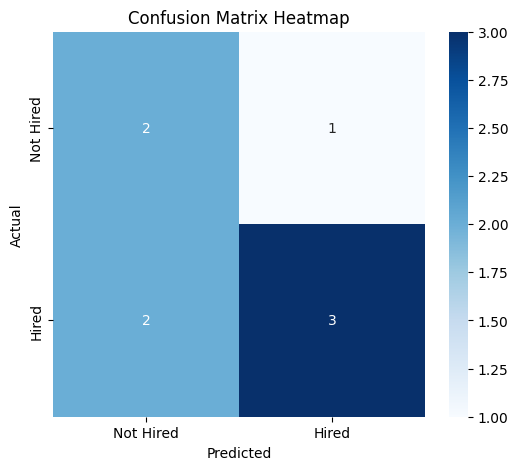

Fairness Metrics: {'Disparate Impact': 0.3333333333333333, 'Equal Opportunity Difference': -0.16666666666666663}
Confusion Metrics: {'Accuracy': 0.625, 'Precision': 0.65625, 'Recall': 0.625, 'F1-score': 0.6309523809523809, 'Confusion Matrix': array([[2, 1],
       [2, 3]])}


In [15]:

# Example usage (replace with actual model results)
y_true_example = [1, 0, 1, 1, 0, 0, 1, 1]  # Ground truth labels
y_pred_example = [1, 0, 0, 1, 0, 1, 1, 0]  # Predicted labels
gender_labels_example = [0, 1, 0, 1, 1, 0, 0, 1]  # Gender labels (0 = Male, 1 = Female)

fairness_metrics = calculate_fairness_metrics(y_true_example, y_pred_example, gender_labels_example)
confusion_metrics = calculate_confusion_metrics(y_true_example, y_pred_example)

print("Fairness Metrics:", fairness_metrics)
print("Confusion Metrics:", confusion_metrics)

In [13]:
# Move model to evaluation mode
model.eval()

y_true = []
y_pred = []

# Disable gradient calculations for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())  # Store true labels
        y_pred.extend(predictions.cpu().numpy())  # Store predictions

# Print extracted predictions
print("Actual Labels (y_true):", y_true)
print("Predicted Labels (y_pred):", y_pred)

Actual Labels (y_true): [9, 9, 9, 20, 7, 17, 5, 12, 2, 7, 20, 1, 5, 24, 15, 8, 0, 10, 21, 22, 18, 3, 21, 24, 24, 0, 6, 6, 12, 1, 14, 3, 16, 4, 13, 24, 19, 1, 4, 16, 14, 0, 16, 18, 4, 24, 11, 3, 9, 10, 9, 6, 13, 8, 9, 20, 3, 18, 8, 1, 6, 6, 15, 4, 11, 14, 1, 21, 21, 15, 21, 16, 22, 11, 17, 11, 2, 17, 5, 7, 9, 13, 13, 16, 15, 23, 18, 16, 2, 12, 22, 21, 12, 24, 15, 15, 24, 1, 14, 1, 19, 5, 16, 7, 14, 23, 7, 18, 7, 7, 9, 14, 16, 12, 11, 14, 24, 21, 24, 8, 13, 9, 1, 23, 8, 23, 19, 1, 18, 16, 15, 16, 23, 9, 22, 18, 3, 24, 11, 8, 15, 9, 5, 19, 19, 16, 9, 14, 3, 9, 20, 15, 19, 10, 14, 13, 8, 9, 8, 1, 22, 6, 14, 11, 16, 24, 10, 1, 4, 5, 9, 6, 16, 6, 23, 5, 24, 24, 1, 19, 5, 14, 8, 23, 14, 16, 24, 24, 15, 0, 0, 19, 24]
Predicted Labels (y_pred): [9, 9, 9, 20, 7, 17, 5, 12, 2, 7, 20, 1, 5, 24, 15, 8, 0, 10, 21, 22, 18, 3, 21, 24, 24, 0, 6, 6, 12, 1, 14, 3, 16, 4, 13, 24, 19, 1, 4, 16, 14, 0, 16, 18, 4, 24, 11, 3, 9, 10, 9, 6, 13, 8, 9, 20, 3, 18, 8, 1, 6, 6, 15, 4, 11, 14, 1, 21, 21, 15, 21, 16, 

In [14]:
# Use extracted predictions for confusion matrix & fairness calculations
y_true_example = y_true
y_pred_example = y_pred

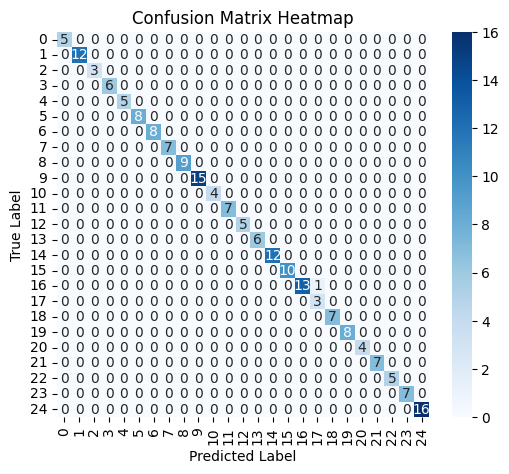

In [18]:

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [30]:
resume_male = "John Doe is a software engineer with experience in Python and AI."
resume_female = "Emily Smith is a software engineer with experience in Python and AI."

print(screen_resume(resume_male))  # What job category & decision?
print(screen_resume(resume_female))  # What job category & decision?


Logits: tensor([[ 0.8701, -0.8473, -0.1774, -0.3023,  0.5627, -0.2148, -0.8910, -0.9213,
         -0.7682,  1.7171,  0.0066,  0.2270, -0.3992, -0.3003,  0.0432,  3.0711,
         -0.4720, -0.3680, -0.9294, -0.1046,  1.0074, -0.8275,  0.2932,  0.0442,
          0.0846]], device='cuda:0', grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.0484, 0.0087, 0.0170, 0.0150, 0.0356, 0.0164, 0.0083, 0.0081, 0.0094,
         0.1129, 0.0204, 0.0254, 0.0136, 0.0150, 0.0212, 0.4371, 0.0126, 0.0140,
         0.0080, 0.0183, 0.0555, 0.0089, 0.0272, 0.0212, 0.0221]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
('Python Developer', 'Reject')

Logits: tensor([[ 8.2076e-01, -7.2724e-01, -3.2172e-01, -2.3420e-01,  4.0892e-01,
         -2.4700e-01, -7.5370e-01, -7.4586e-01, -7.3198e-01,  1.6586e+00,
         -1.0078e-02,  1.8925e-01, -4.2618e-01, -1.5540e-01,  2.0361e-02,
          3.0573e+00, -5.5071e-01, -1.3843e-01, -8.5585e-01, -8.9844e-02,
          1.0311e+00, -9.0490e-01, -1.9877e-03,  2.94

In [29]:
print(df.columns)

Index(['Category', 'Resume', 'Label'], dtype='object')


In [28]:
print("Sample Predictions:", y_pred[:10])
print("Sample True Labels:", y_true[:10])
print("Sample Sensitive Attributes:", sensitive_attr[:10])

Sample Predictions: [9, 9, 9, 20, 7, 17, 5, 12, 2, 7]
Sample True Labels: [9, 9, 9, 20, 7, 17, 5, 12, 2, 7]


NameError: name 'sensitive_attr' is not defined

In [27]:
import pandas as pd

def demographic_parity(y_pred, sensitive_attr):
    """
    Computes Demographic Parity by checking selection rates for different groups.
    """
    df = pd.DataFrame({'y_pred': y_pred, 'sensitive_attr': sensitive_attr})
    print("\n📊 Data Preview:\n", df.head())  # Debugging

    if df.empty:
        print("🚨 Error: DataFrame is empty. Check input values.")
        return None

    selection_rates = df.groupby('sensitive_attr')['y_pred'].mean()
    print("\n✅ Selection Rate per Group:\n", selection_rates)

    if len(selection_rates) < 2:
        print("⚠ Not enough groups to compare fairness!")
        return None

    disparity_ratio = min(selection_rates) / max(selection_rates) if max(selection_rates) > 0 else 0
    print(f"\n⚖ Disparity Ratio: {disparity_ratio:.2f} (Ideal: ~1)\n")

# 📌 Call the function
# demographic_parity(y_pred, sensitive_attr)

In [26]:
def demographic_parity(y_pred, sensitive_attr):
    df = pd.DataFrame({'y_pred': y_pred, 'sensitive_attr': sensitive_attr})

    print("📌 Data Preview:\n", df.head())  # ✅ Debugging line
    print(f"📌 y_pred Length: {len(y_pred)}, sensitive_attr Length: {len(sensitive_attr)}")  # ✅ Check lengths

    if df.empty:
        print("⚠️ Error: DataFrame is empty. Check input values.")
        return

    selection_rates = df.groupby('sensitive_attr')['y_pred'].mean()

    print("\n📊 Demographic Parity (Selection Rate per Group):")
    print(selection_rates)

    disparity_ratio = min(selection_rates) / max(selection_rates) if max(selection_rates) > 0 else 0
    print(f"\n⚖ Disparity Ratio: {disparity_ratio:.2f} (Ideal: ~1)\n")


In [23]:
import pandas as pd

def demographic_parity(y_pred, sensitive_attr):
    """
    Computes Demographic Parity by checking selection rates for different groups.

    y_pred: Model's predicted hiring decision (0 = Rejected, 1 = Hired)
    sensitive_attr: List of protected attribute values (e.g., gender: 0 for male, 1 for female)
    """
    df = pd.DataFrame({'y_pred': y_pred, 'sensitive_attr': sensitive_attr})
    print("Data Preview:\n", df.head())  # Debugging statement

    if df.empty:
        print("Error: DataFrame is empty. Check input values.")
        return

    # Compute selection rate for each group
    selection_rates = df.groupby('sensitive_attr')['y_pred'].mean()

    print("\n📊 Demographic Parity (Selection Rate per Group):")
    print(selection_rates)

    # Compute disparity ratio
    disparity_ratio = min(selection_rates) / max(selection_rates) if max(selection_rates) > 0 else 0
    print(f"\n⚖ Disparity Ratio: {disparity_ratio:.2f} (Ideal: ~1)\n")

# Example Test Call
# demographic_parity(y_pred, gender_labels)

In [21]:
from sklearn.metrics import confusion_matrix

def equal_opportunity(y_pred, y_true, sensitive_attr):
    """
    Computes Equal Opportunity (True Positive Rate Parity).

    y_pred: Model's predicted hiring decision
    y_true: Actual hiring labels
    sensitive_attr: List of protected attribute values (e.g., gender: 0 for male, 1 for female)
    """
    df = pd.DataFrame({'y_pred': y_pred, 'y_true': y_true, 'sensitive_attr': sensitive_attr})

    # Compute True Positive Rate (TPR) for each group
    tpr_per_group = {}

    for group in df['sensitive_attr'].unique():
        group_data = df[df['sensitive_attr'] == group]
        tn, fp, fn, tp = confusion_matrix(group_data['y_true'], group_data['y_pred']).ravel()
        tpr_per_group[group] = tp / (tp + fn) if (tp + fn) > 0 else 0

    print("Equal Opportunity (TPR per Group):")
    print(tpr_per_group)

# Example Usage:
# equal_opportunity(y_pred, y_true, gender_labels)